In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim

from itertools import product

# Always make it pretty.
plt.style.use('ggplot')

import samplers as spl

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


# The Central Limit Theorem and Boostrapping

### The Normal (Gaussian) Distribution

The **normal** or **gaussian** distribution has a hallowed place in statistical folklore, mostly due to the **central limit theorem** which we will study shortly.

The traditional notation for a normal random variable is $Z$ (instead of $X$, used for pretty much any other random variable).

A normal random variable $Z$ has the distribution function

$$ \Phi (t) = \frac{1}{\sqrt{2 \sigma^2 \pi}} \int_{- \infty}^t e^{ - \frac{(x - \mu)^2}{2 \sigma^2} } dx $$

The $\Phi$ is, again, traditional notation for the distribution function of a normal random variable. 

By differentiating, we get the density function of a normal random variable

$$ \phi (t) = \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{ - \frac{(x - \mu)^2}{2 \sigma^2} } $$

The integral for the CDF of the normal distribution does *not* have a closed form.  In practice, the only way to compute values of the distribution function of a normal random variable is to use a computer.

### Parameters of the Normal Distribution

The $\mu$ and $\sigma$ are the parameters of the distribution.  

Changing $\mu$ translates the distribution function to the right and left

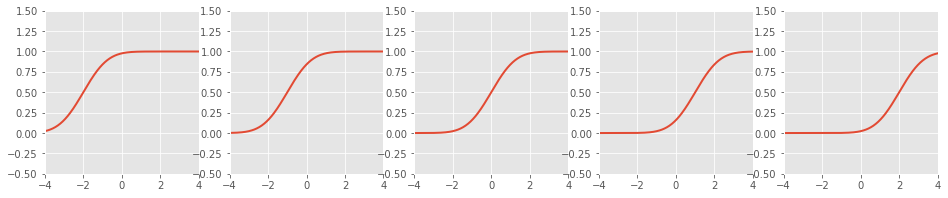

In [2]:
normal_dists_varying_mean = [
    spl.Normal(mu, 1) for mu in [-2, -1, 0, 1, 2]
]

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3))

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_mean[i].cdf(x), linewidth=2)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlim(-4, 4)

Changing $\sigma$ stretches and shrinks the distribution function horisontally

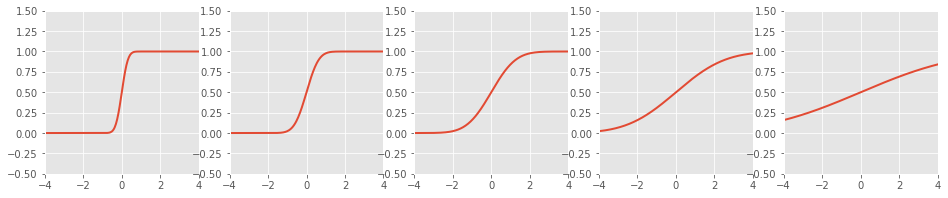

In [3]:
normal_dists_varying_sigma = [
    spl.Normal(0, sigma) for sigma in [0.25, 0.5, 1, 2, 4]
]

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3))

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_sigma[i].cdf(x), linewidth=2)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlim(-4, 4)

Text(0.5,1,'Normal(0, 1) Density Function')

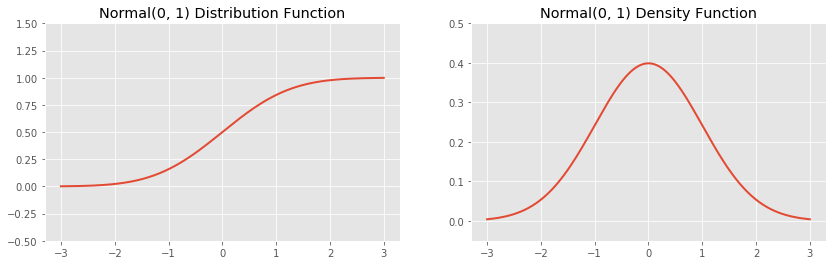

In [4]:
normal = spl.Normal(0, 1)

x = np.linspace(-3, 3, num=250)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(x, normal.cdf(x), linewidth=2)
ax[0].set_ylim(-0.5, 1.5)
ax[0].set_title("Normal(0, 1) Distribution Function")

ax[1].plot(x, normal.pdf(x), linewidth=2)
ax[1].set_ylim(-0.05, 0.5)
ax[1].set_title("Normal(0, 1) Density Function")

Text(0.5,1,'Normal(0, 1)) Density Function')

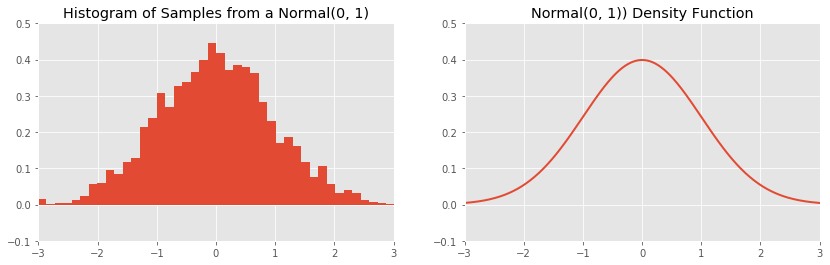

In [5]:
normal_samples = normal.sample(2500)

x = np.linspace(-3, 3, num=250)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(normal_samples, bins=50, normed=True)
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-0.1, 0.5)
ax[0].set_title("Histogram of Samples from a Normal(0, 1)")

ax[1].plot(x, normal.pdf(x), linewidth=2)
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-0.1, 0.5)
ax[1].set_title("Normal(0, 1)) Density Function")

## The Central Limit Theorem

### The Distribution of the Sample Means

Let's return to the distribution of a very popular statistic, the **distribution of the sample means**.

Consider a fixed population, and for the moment, suppose we have the power to sample freely, as many data points as we wish

In [6]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])

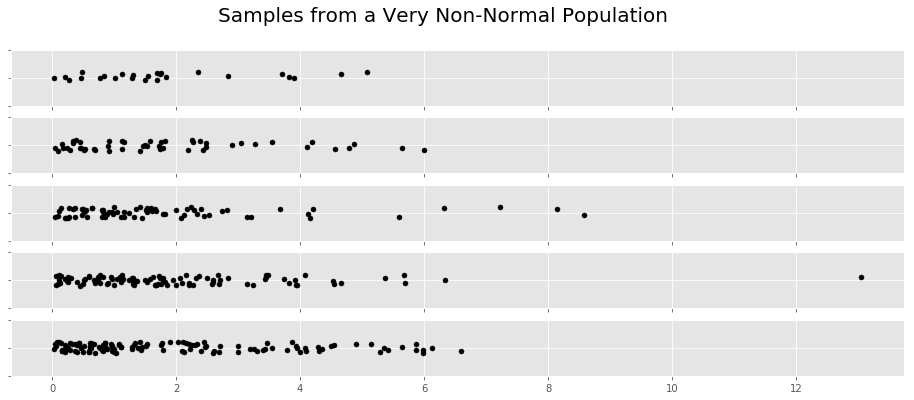

In [7]:
fig, axs = plt.subplots(5, figsize=(16, 6), sharex=True)

population = spl.Exponential(2)
sample_sizes = [25, 50, 75, 100, 125]
for sample_size, ax in zip(sample_sizes, axs.flatten()):
    sample = population.sample(sample_size)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    
_ = fig.suptitle("Samples from a Very Non-Normal Population", fontsize=20)

Suppose we fix a sample size, and repeatedly sample from the population with that fixed size

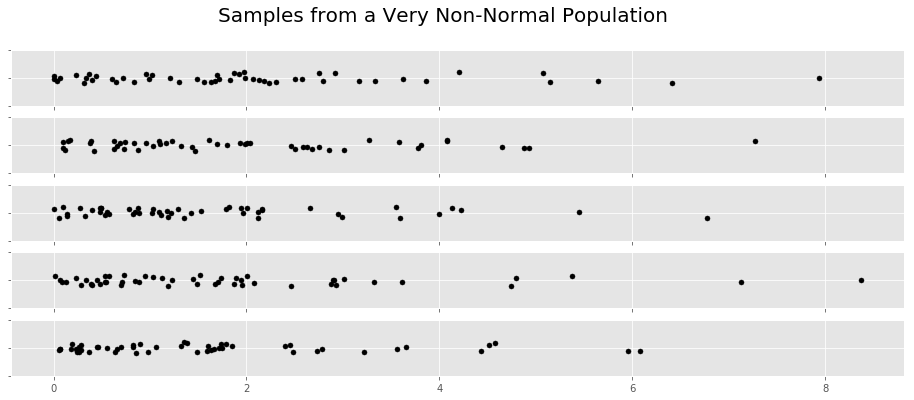

In [8]:
fig, axs = plt.subplots(5, figsize=(16, 6), sharex=True)

for sample_size, ax in zip(sample_sizes, axs.flatten()):
    sample = population.sample(50)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    
_ = fig.suptitle("Samples from a Very Non-Normal Population", fontsize=20)

Remember, the **sampling distribution of the mean** is the distribution of the means computed from these *different samples*.

Here, we've superimposed the sample means on each of our sample means.



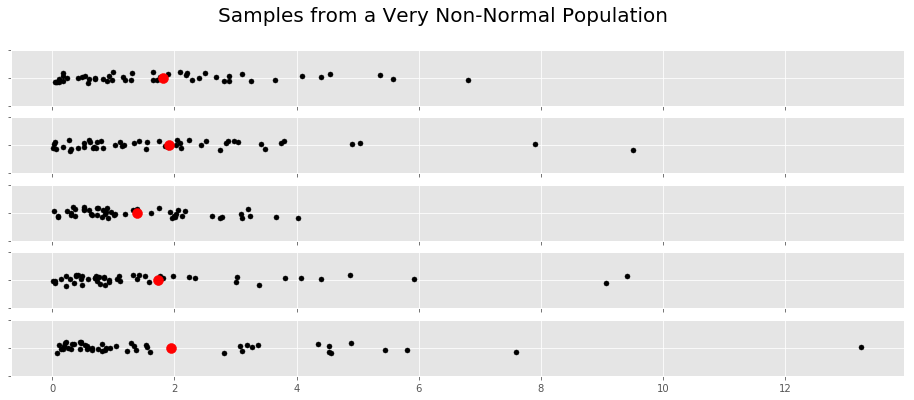

In [9]:
fig, axs = plt.subplots(5, figsize=(16, 6), sharex=True)

for sample_size, ax in zip(sample_sizes, axs.flatten()):
    sample = population.sample(50)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax.scatter(sample.mean(), 0, color='red', s=100)
    
_ = fig.suptitle("Samples from a Very Non-Normal Population", 
                 fontsize=20)

Let's do that, let's repeatedly sample, compute the means of the samples, then plot the distribution of these means.

Each of the red dots in the above visualization is counted **one time** in the histogram below.

In [10]:
def smfp(n_samples, n_summands, sampler): 
    return (1.0/n_summands) * spl.sample_from_repeated_sum(n_samples, n_summands, sampler)

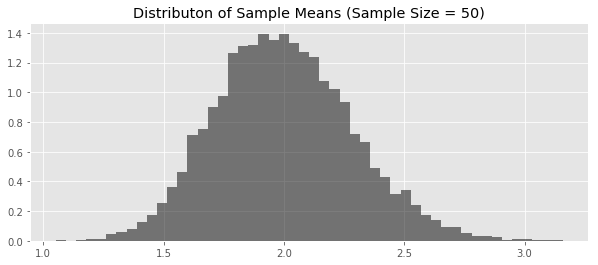

In [11]:
sample_means = smfp(n_samples=10000, n_summands=50, sampler=population)

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(sample_means, bins=50, normed=True, color="black", alpha=0.5)
_ = ax.set_title("Distributon of Sample Means (Sample Size = 50)")

The averaging has greatly reduced the rightward skew of our original distribution. Our process has smothed out and symmetricized the original distribution.

Let's overlay a normal distribution with the correct mean and variance.

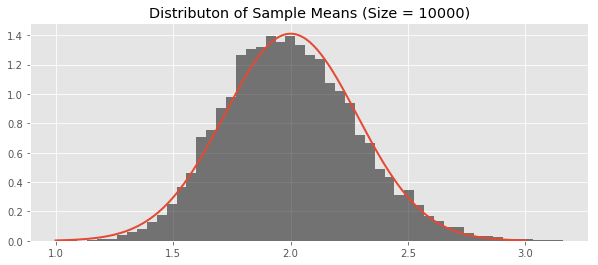

In [12]:
mean_sample_means = np.mean(sample_means)
variance_sample_means = np.var(sample_means)
sample_means_model = spl.Normal(mean_sample_means, 
                                np.sqrt(variance_sample_means))

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(sample_means, bins=50, normed=True, color="black", alpha=0.5)
x = np.linspace(1, 3, num=250)
ax.plot(x, sample_means_model.pdf(x), linewidth=2)
_ = ax.set_title("Distributon of Sample Means (Size = 10000)")

Yah, that looks pretty close.

### The Central Limit Theorem

The **central limit theorem** asserts that as we take the mean of larger and larger samples, the distribution of sample means becomes more and more normal.

Said differently, probabilistic statements about the mean of a large sample can be well approximated by assuming that the distribution of the sample means is a normal distribution with the correct mean and variance.

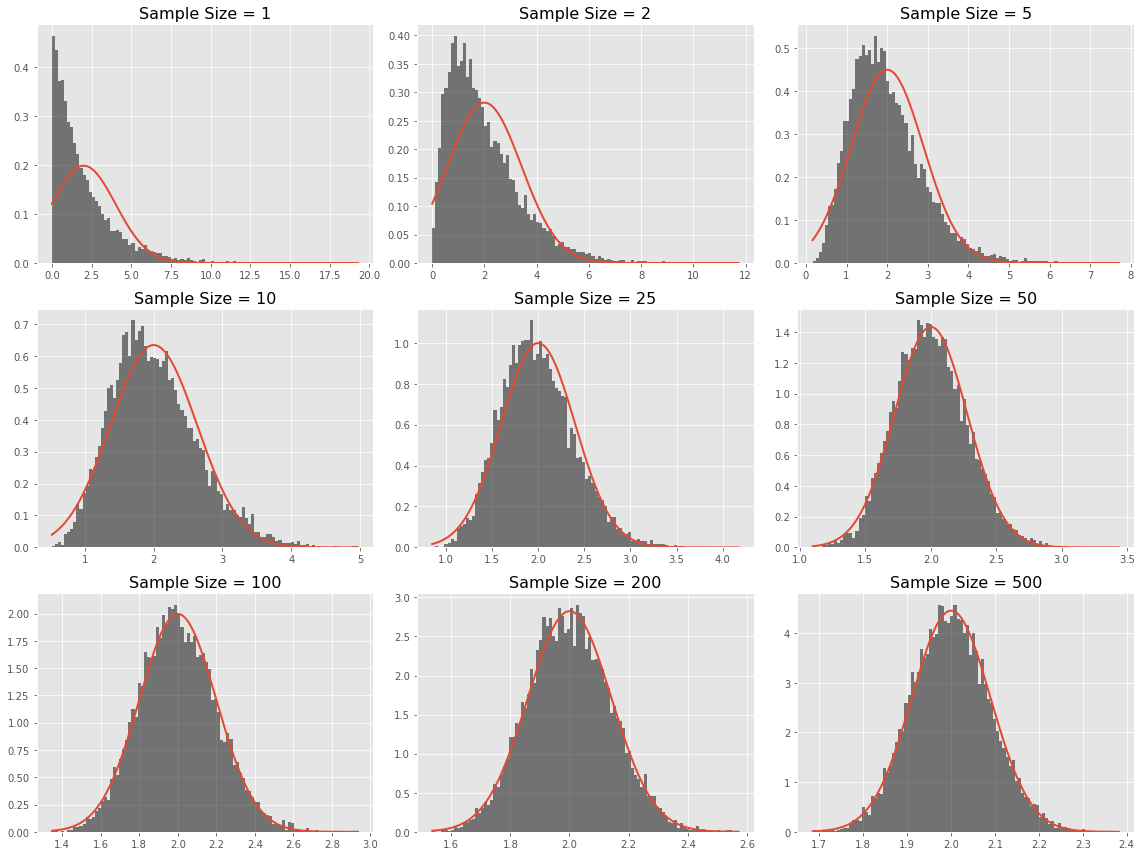

In [13]:
size_of_sample = [1, 2, 5, 10, 25, 50, 100, 200, 500]

fig, axs = plt.subplots(3, 3, figsize=(16, 12))

for sample_size, ax in zip(size_of_sample, axs.flatten()):
    sample_means = spl.sample_means_from_population(
        n_samples=10000, n_summands=sample_size, sampler=population)
    variance_sample_means = np.var(sample_means)
    sample_means_model = spl.Normal(mean_sample_means, 
                                    np.sqrt(variance_sample_means))
    ax.hist(sample_means, bins=100, normed=True, color="black", alpha=0.5)
    t = np.linspace(min(sample_means), max(sample_means), num=250)
    ax.plot(t, sample_means_model.pdf(t))
    _ = ax.set_title("Sample Size = {}".format(sample_size), fontsize=16)
fig.tight_layout()

### Statement of he Central Limit Theorem

Suppose $X_1, X_2, \ldots$ are i.i.d. copies of a random varaiable with finite expectation and variance

$$ E[X_1] = E[X_2] = \cdots = \mu $$
$$ var[X_1] = var[X_2] = \cdots = \sigma^2 $$

Then the distribution of sample means tends to a normal distribution with the appropriate mean and standard deviation:

$$ \frac{X_1 + X_2 + \cdots + X_k}{k} \rightarrow N \left( \mu, \frac{\sigma}{\sqrt{k}} \right) $$

as $k \rightarrow \infty$.

**Note:** The CLT also applies to a simple sum, though the mean and variance are different

$$ X_1 + X_2 + \cdots + X_k \rightarrow N \left( k \mu, \sqrt{k} \sigma \right) $$

The type of convergence is the CLT is called [convergence in distribution](https://en.wikipedia.org/wiki/Convergence_of_random_variables#Convergence_in_distribution).

A couple of notes

  - The stunning part of the central limit theorem is that it makes almost no assumptions about $X$.  $X$ can be anything, and it's sample means will always tend to be normal.
  - The central limit theorem is a **miracle**, pure and simple.  There is no real *reason* it is true, it just is.  Consider it a gift of rare order in the universe, more like a fundamental law of physics than an intuitive mathematical fact.
  - Here's an elevator pitch statement of the central limit theorem, good for job interviews: **The central limit theorem allows us to make probabilistic statements about the sample mean from any population using the normal distribution.**

### Example: The Binomial Distribution

Consider a binomial distribution $Binom(n, p)$, which assigns probabilities to the number of heads shown in $n$ flips of a coin where the probability of seeing a head in a **single flip** is $p$.

Consider a variable $X$ which is distributed as binomial

$$ X \sim Binom(n, p) $$

and also a ton of variables representing **single coin flips**

$$ X_1, X_2, \ldots \sim Binom(1, p) $$

**Claim:** $X \sim X_1 + X_2 + \cdots + X_n$

**Question:** Why?

The central limit theorem has an immediate consequence:  Binomial distributions with large $n$ tend to be approximately normal!

$$ Binom(n, p) \sim N(np, \sqrt{n p (1 - p)} ) $$

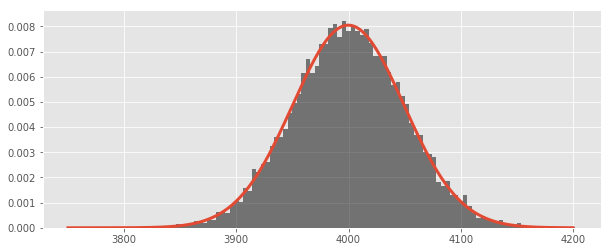

In [14]:
binomial = spl.Binomial(10000, 0.4)
binomial_sample = binomial.sample(10000)

binomial_sample_mean = np.mean(binomial_sample)
binomial_sample_variance = np.var(binomial_sample)
normal_approx = spl.Normal(binomial_sample_mean, np.sqrt(binomial_sample_variance))

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(binomial_sample, bins=100, normed=True, color="black", alpha=0.5)
x = np.linspace(3750, 4200, num=250)
ax.plot(x, normal_approx.pdf(x), linewidth=3)

An immediate consequence: Binomial probabilities with large $n$ can be well approximated using the normal distribution.

#### Example: Binomial Probabilities

You flip a coin 100000 times.  What is the probability that you flip heads between 57000 and 

### Important Note

The central limit theorem let's us make probabilistic statements about a very specific sample statistic: the sample mean.  Because of this, much emphasis is placed on the sample mean in many courses on statistics.

**The sample mean is not the only important statistic**, if you are trying to estimate hurricane losses, the mean loss is probably not as important as, say, the *maximum possible loss*.  The central limit theorem has **nothing** to say about this situation.

The central limit theorem is an important tool, but it is not **general**.  Other tools would be rightfully viewed as more important, i.e. bootstrapping.

### The Central Limit Theorem: The Point

When we are concerned with a **sample mean**, the central limit theorem lets us derive the **actual distribution of the sample mean**.  This allows us to calculate probabilities about the sample mean.

We are going to make good use of this next lesson when we design statistical hypothesis tests.

## The Bootstrap

The central limit theorem is nice, it is a central result in mathematical statistics, and there is no other result in the subjects with the definitive nature of the CLT.

On the other hand, it has a huge drawback: **it only works for a single statistic, the sample mean!**  It would be nice to have a general procedure that will let us estimate the varaince (or the entire distribution) of **any sample statisic**.

### Bootstrap Samples

We generally have one fixed dataset, which we view as a single sample from the population.  **The population is the object that interests us, and the sample is the lens through which we get to view it.**

The idea behind the bootstrap is that the **empirical distribution** of the sample should be our **best approximation** to the distribution of the population the sample is drawn from.  We can illistrate this by comapring the emperical distribution functions of samples to the actual population distribution functions:

In [15]:
def superimpose_pdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    _ = ax.hist(data, bins=25, normed=True, color="black", alpha=0.4)
    ax.plot(x, model.pdf(x), linewidth=3)
    
def superimpose_cdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    ax.plot(x, emperical_distribution(x, data), linewidth=2)
    ax.plot(x, model.cdf(x), linewidth=2)
    
def emperical_distribution(x, data):
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

Text(0.5,0.98,'Population vs. Sample CDFs')

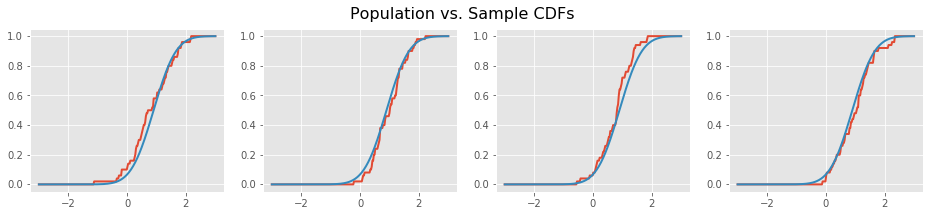

In [16]:
population = spl.Normal(0.9, 0.6)

fig, axs = plt.subplots(1, 4, figsize=(16, 3))

for ax in axs.flatten():
    sample = population.sample(50)
    superimpose_cdf_of_fit_model(sample, population, ax)
fig.suptitle("Population vs. Sample CDFs", fontsize=16)

Text(0.5,0.98,'Population vs. Sample CDFs')

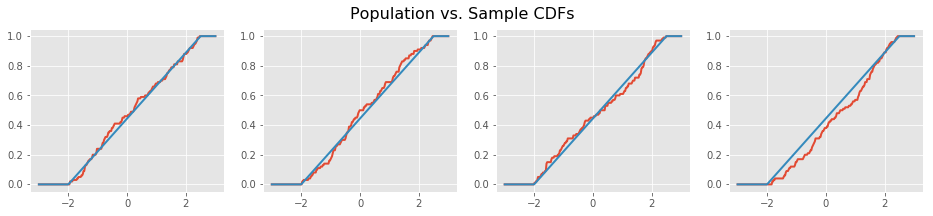

In [17]:
population = spl.Uniform(-2, 2.5)

fig, axs = plt.subplots(1, 4, figsize=(16, 3))

for ax in axs.flatten():
    sample = population.sample(100)
    superimpose_cdf_of_fit_model(sample, population, ax)
fig.suptitle("Population vs. Sample CDFs", fontsize=16)

This means that  **since we cannot repeatedly sample from the population, our next best bet is to sample from the sample itself**.

#### Bootstrap: The Big Idea

We want to do this:

> Estimate the variance of a sample statistic by repeatedly sampling from the population, computing the sample means of these samples, and then computing the variance of the multiple sample means.

But we **can't**, because we can **only sample from the population one time**.

Instead, we repeatedly sample from our **best approximation to the population distribution**, which is given by the **empirical density function of the sample**.

That is, instead we do

> Estimate the variance of the sample means by repeatedly sampling from *a distribution approximating the population distribution*, computing the sample means of these samples, and then computing the variance of the multiple sample means.

### Definition

A **bootstrap sample** from a dataset is a sample taken with replacement from that dataset whose size is the size of the dataset itself.

In [18]:
data = spl.secret_data()

In [19]:
def text_in_blank_plot(text, ax):
    _ = ax.text(0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=22)
    ax.axis('off')

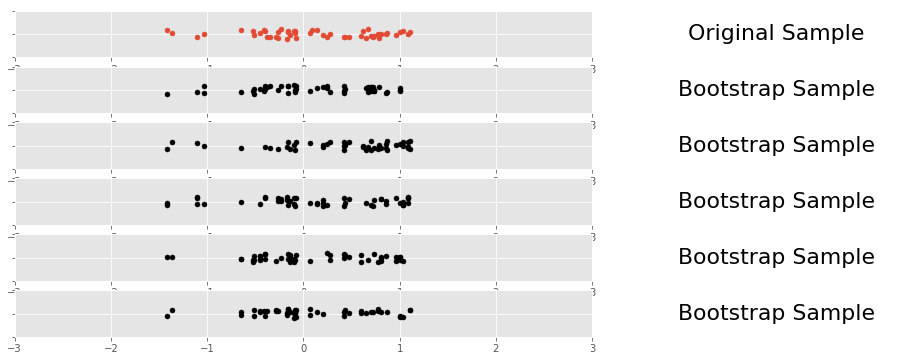

In [20]:
fig = plt.figure(figsize=(16, 6))

ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("Original Sample", ax)

for i in range(0, 5):
    bootstrap = np.random.choice(data, size=len(data), replace=True)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(bootstrap, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Bootstrap Sample", ax)

Each bootstrap sample has it's **own** sample mean

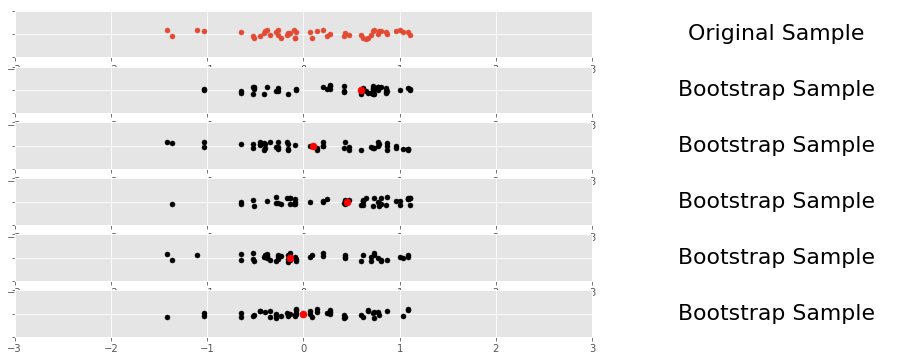

In [21]:
fig = plt.figure(figsize=(16, 6))

ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("Original Sample", ax)

for i in range(0, 5):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(bootstrap_sample, ax, c="black", s=25)
    sample_mean = np.median(bootstrap_sample)
    ax.scatter([sample_mean], 0, c="red", s=50)
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Bootstrap Sample", ax)

The sample means taken from repeated bootstrap samples are then an approximation to the **distribution of the sample medians**

In [22]:
def bootstrap_sample_medians(data, n_bootstrap_samples=10000):
    bootstrap_sample_medians = []
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_sample_medians.append(np.median(bootstrap_sample))
    return bootstrap_sample_medians

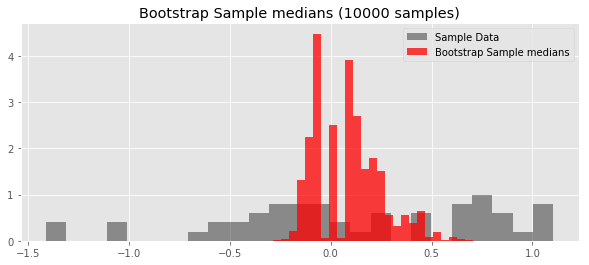

In [23]:
bootstrap_medians = bootstrap_sample_medians(data)

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(data, bins=25, normed=True, color="black", alpha=0.4,
            label="Sample Data")
_ = ax.hist(bootstrap_medians, bins=25, normed=True, color="red", alpha=0.75,
            label="Bootstrap Sample medians")
ax.legend()
_ = ax.set_title("Bootstrap Sample medians (10000 samples)")

We can now use the bootstrap distribution of the sample meadian to estimate statistics that would otherwise be un-aprochable.

In [24]:
variance_of_sample = np.var(data)
varaince_of_bootstrap_medians = np.var(bootstrap_medians)

print("Variance of Sample: {:2.2f}".format(variance_of_sample))
print("Variance of Sample medians: {:2.2f}".format(varaince_of_bootstrap_medians))

Variance of Sample: 0.41
Variance of Sample medians: 0.03


### Bootstrap: The Point

The Bootstrap is a tool to **quantify the variation in a statistical estimate**.  It can be used in almost **any** situation.

The bootstrap is a giant point in favor of the massive amount of computation all of us has at our disposal in modern day.  Before the computer age, the practice of statistics was tedious and mathematical.  Now we can estimate things earlier generaitions would **never have dreamed of** by simply putting to work some carefully engeneered slabs of silicon.

**Question:** Are there any statistics where the bootstrap will *not* work to quantify variation?

## Confidence Intervals: Capturing Population Parameters

Recall our statement from earlier

> Our general interest is in the **population**, the **sample** is just the lens we get to view it through.

We have shown that **sample statistics are generally good approximations of properties of the population**, and we have also discovered **methods for approximating the distribution of sample statistics**  such as bootstrapping and the central limit theorem.

Together these allow us to address a final question

> How good of an approximation of a population parameter is a sample statistic?

### Example: CLT Based Confidence Interval for the Sample Mean

Consider our sample from a secret population, which we have used as a running example

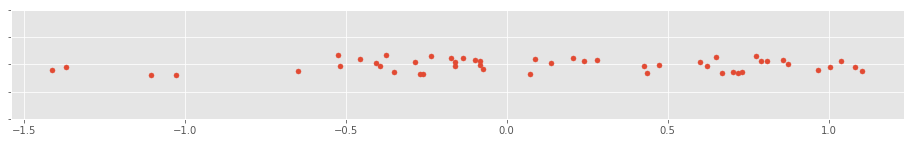

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

Here are the facts we have accumulated about this situation

  - The sample mean is an approximation of the population mean: the expected value of the sample mean *is* the population mean.
  - The sample mean is approximately normally distributed, the mean and variance of this normal distribution can be computed in terms of the population mean and variance, and the size of the sample.
  
Let's denote by 
  - $\mu$ the population mean.
  - $\sigma^2$ the population variance.
  - $\bar x$ the **sample mean**.
  
Then we can summarize all this as

$$ \bar x \sim N \left( \mu, \frac{\sigma}{\sqrt{n}} \right) $$

If we subtract the population mean from both sides we get

$$ \bar x - \mu \sim N \left( 0, \frac{\sigma}{\sqrt{n}} \right) $$

Which allows us to make probabilistic statements about how far the sample mean is from the population mean.

A **confidence interval** is the answer to a question like this

> How far do I have to go to the left and the right of the sample mean so that 95% of the time (i.e. in 95% of possible samples) I will have enclosed the population mean?

Let $\alpha$ denote the distance you move to the left and right of the sample mean when drawing your interval.  In notation, we are asking to find $\alpha$ such that

$$ P(\bar x - \alpha \leq \mu \leq \bar x + \alpha) = 0.95 $$

This is the same as asking for

$$ P( - \alpha \leq \mu - \bar x \leq \alpha ) = 0.95 $$

The thing in the middle here, $\mu - \bar x$, has a known distribution!

$$ \bar x - \mu \sim N \left( 0, \frac{\sigma}{\sqrt{n}} \right) $$

So, visually, we are looking for:

[]

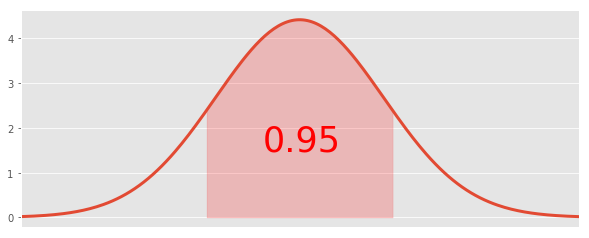

In [37]:
sample_mean = np.mean(data)
sample_varaince = np.var(data)
distribution_of_sample_minus_population_mean = spl.Normal(0, np.sqrt(sample_varaince / len(data)))

fig, ax = plt.subplots(1, figsize=(10, 4))
x = np.linspace(-0.3, 0.3, num=250)
pdf = distribution_of_sample_minus_population_mean.pdf(x)
ax.plot(x, pdf, linewidth=3)

# Shade under curve
# Note: The 0.1 here is just for illistration, it does not correspond to
#       any particular value of alpha.
ax.set_xlim(-0.3, 0.3)
ax.fill_between(x, pdf, 0, 
                where=( (-0.1 <= x) * (x <= 0.1) ), color="red", alpha=0.2)
ax.text(-0.04, 1.5, "0.95", fontsize=35, color="red")
ax.set_xticks([])

The shaded region is the area under the density between $-\alpha$ and $\alpha$. We want the **shaded region** to account for $0.95$ of the total area.

This means that each *half* of the shaded area to the *left and right* of zero should account for $0.475$ of the total area.

[]

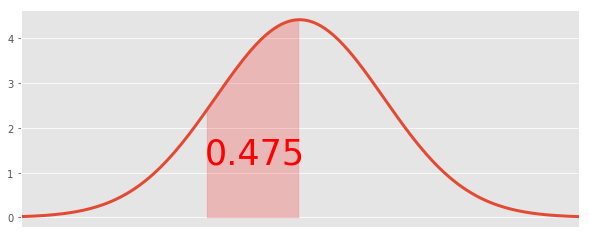

In [27]:
fig, ax = plt.subplots(1, figsize=(10, 4))

ax.plot(x, pdf, linewidth=3)

# Shade under curve
ax.set_xlim(-0.3, 0.3)
ax.fill_between(x, pdf, 0, 
                where=( (-0.1 <= x) * (x <= 0.0) ), color="red", alpha=0.2)
ax.text(-0.102, 1.2, "0.475", fontsize=35, color="red")
ax.set_xticks([])

Which means that the "tail" to the left of $\alpha$ should account for $0.5 - 0.475 = 0.025$ of the total area.

[]

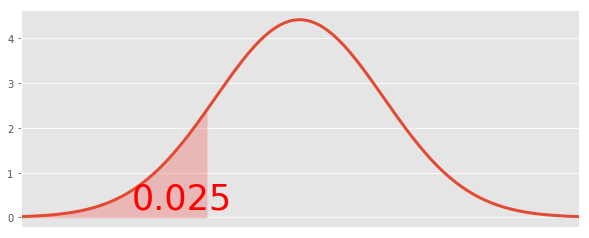

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 4))

ax.plot(x, pdf, linewidth=3)

# Shade under curve
ax.set_xlim(-0.3, 0.3)
ax.fill_between(x, pdf, 0, 
                where=( (x <= -0.1) ), color="red", alpha=0.2)
ax.text(-0.18, 0.2, "0.025", fontsize=35, color="red")
ax.set_xticks([])

It is **this kind of area that is computed by the distribution function**.

So, if we denote by $F$ the **distribution function of** $ N \left( 0, \frac{\sigma}{\sqrt{n}} \right) $, then we are after the value of $\alpha$ satisfying

$$ F(-\alpha) = 0.025 $$

Or $$F^{-1}(0.025) = -\alpha$$

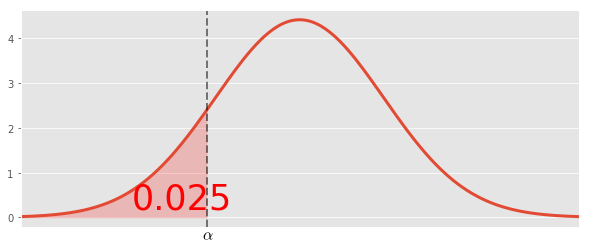

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 4))

ax.plot(x, pdf, linewidth=3)

# Shade under curve
ax.set_xlim(-0.3, 0.3)
ax.fill_between(x, pdf, 0, 
                where=( (x <= -0.1) ), color="red", alpha=0.2)
ax.text(-0.18, 0.2, "0.025", fontsize=35, color="red")
ax.axvline(x=-0.1, ymin=0.0, ymax=100, color="black", 
           linestyle='--', alpha=0.5)
ax.text(-0.105, -0.5, r"$\alpha$", fontsize=16)
_ = ax.set_xticks([])

The **inverse of the distribution function** is often called the **percentile function**.

In [30]:
alpha = distribution_of_sample_minus_population_mean.percentile(0.025)
print("Sample Mean: {:2.2}".format(sample_mean))
print("95% confidence interval for the population mean: [{:2.2}, {:2.2}]".format(
    sample_mean + alpha, sample_mean - alpha)
    )

Sample Mean: 0.12
95% confidence interval for the population mean: [-0.062, 0.29]


Recall our interpretation here

> If we draw samples from the population and compute this confidence interval many, many times, then the computed interval should envelop the true population parameter approximately 95% of the time.

In this case, I wrote the code to create the population, so I know the correct answer

**The population mean is $0.1$.**

So let's run a simulation and see if everything worked.

In [40]:
def compute_confidence_interval(data, confidence_width):
    sample_mean = np.mean(data)
    sample_varaince = np.var(data)
    distribution_of_sample_minus_population_mean = spl.Normal(0, np.sqrt(sample_varaince / len(data)))
    alpha = distribution_of_sample_minus_population_mean.percentile(0.5 - (confidence_width / 2.0))
    # Alpha is negative
    return sample_mean + alpha, sample_mean - alpha

In [41]:
population_mean_is_in_interval = []
for i in range(1000):
    new_data = spl.secret_data()
    left_endpoint, right_endpoint = compute_confidence_interval(new_data, 0.95)
    population_mean_is_in_interval.append(left_endpoint <= 0.1 <= right_endpoint)
    
print("Proportion of confidence intervals containing the true parameter: {:2.2f}".format(
        np.mean(population_mean_is_in_interval)))

Proportion of confidence intervals containing the true parameter: 0.94


Which is what we would expect.

To dive the point home, we can plot all of these confidence intervals along with the true parameter, and visually see which do and do not contain the parameter.

Text(0.5,1,'Coverage of Confidence Intervals')

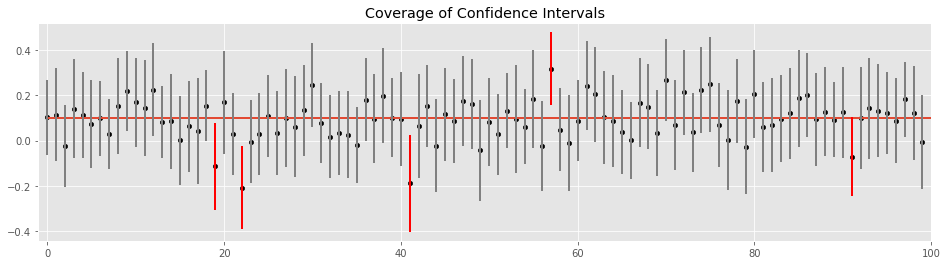

In [42]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot([0, 100], [0.1, 0.1])

for i in range(100):
    new_data = spl.secret_data()
    sample_mean = new_data.mean()
    left_endpoint, right_endpoint = compute_confidence_interval(new_data, 0.95)
    color = "grey" if (left_endpoint <= 0.1 <= right_endpoint) else "red"
    ax.plot([i, i], [left_endpoint, right_endpoint], color=color)
    ax.scatter([i], [sample_mean], c="black", s=20)
    ax.set_xlim(-1, 100)
    
ax.set_title("Coverage of Confidence Intervals")

### Example: Bootstrap Confidence Interval for 75'th Percentile

The above example relied on the central limit theorem to provide the sampling distribution of the statistic, which is only possible for very specific sample statistics.

Consider estimating a confidence interval of the 75'th percentile of a population.  In this case, the central limit theorem does not allow us to derive a mathematical form of the sampling distribution, instead we can proceed by using bootstrap sampling.

Here is the bootstrap procedure for computing a confidence interval for a 75'th percentile

  - Draw many bootstrap samples from your main sample, and for each:
    - Compute the sample statistic (using the bootstrap sample)
  - Gather together all the sample statistics of the various bootstrap samples into a list.
  
The resulting list can be considered as a sample from the sampling distribution of the statistic.

  - Compute the 95% confidence interval by finding the 0.025 and 0.975 percentiles of the resulting list of sample statistics.

In [43]:
bootstrap_sample_75_percentiles = []
for i in range(10000):
    bootstrap = np.random.choice(data, size=len(data), replace=True)
    bootstrap_75_percentile = np.percentile(bootstrap, 75)
    bootstrap_sample_75_percentiles.append(bootstrap_75_percentile)

This code creates an approximation the the sampling distribution of the statistic.

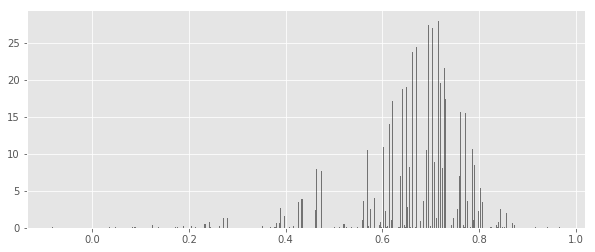

In [44]:
fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(bootstrap_sample_75_percentiles, bins=500, normed=True, color="black", alpha=0.5)

We get a confidence interval by computing the 0.025 and 0.975 percentiles of the resulting sampling distribution approximation

In [45]:
left_endpoint = np.percentile(bootstrap_sample_75_percentiles, 2.5)
right_endpoint = np.percentile(bootstrap_sample_75_percentiles, 97.5)

print("Sample 75'th Percentile: {:2.2f}".format(np.percentile(data, 75)))
print("Bootstrap Confidence Interval for Population 75'th Percentile: [{:2.2f}, {:2.2f}]".format(
    left_endpoint, right_endpoint))

Sample 75'th Percentile: 0.70
Bootstrap Confidence Interval for Population 75'th Percentile: [0.42, 0.80]


**Question:** Why is this confidence interval not symmetric?